In this notebook we will compare the MBR scores calculated with the monte-carlo estimates and those from the predictive model
We will try to analyse failure points and think about how to tackle those.



In [1]:
# Some setup code for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the test set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("test", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset = dataset_loader.load(type="pandas")

In [3]:
# We will visualize the scores as



In [4]:
import numpy as np
def calculate_mbr_scores(entry, n_references=1000):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util* entry["utilities_count"])/count
        scores.append(score)
    return scores

In [5]:
entry_id=5
entry = dataset.data.iloc[entry_id]
scores = calculate_mbr_scores(entry)

print(scores)

[1.1133391144815832, 0.9755134445149451, 0.905233200730756, -1.3698183157444, -1.1949610184133053, 1.0327796646803618, 1.01902508867532, 0.7112088796794415, 0.7830700763016939, 0.8376556033492089, 0.5338141671177, 0.7649866837505251, 0.6780157202705741, 0.8344538183510304, 0.8344893747251481, -0.8230702860951423, 0.8618518640194088, 0.2451410574503243]


In [6]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory
path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/best_100_1000_no_repeat/"
model, factory = PLPredictiveModelFactory.load(path)

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
1.001726887106992e-06
using a full model


In [7]:
from models.MBR_model.MBRModel import MBRModel
wrapped_model = MBRModel(model)

In [8]:
from tqdm import tqdm
all_scores = []
for i, row in tqdm(dataset.data.iterrows(), total=dataset.data.shape[0]):
    source = row["source"]
    hypotheses = list(row["hypotheses"])

    scores = wrapped_model.get_scores([source]* len(hypotheses), hypotheses)
    all_scores.append(scores)
    
    if i > 200:
        break


  4%|███▏                                                                           | 201/5000 [00:15<06:13, 12.85it/s]


In [9]:
import matplotlib.pyplot as plt
def clean(s):
    return s.replace('?', '')

def compare_scores(source, target, hypotheses, monte_carlo_scores, predicted_scores, max_show=15, labels=("Monte Carlo", "predicted"), colors=("b", "r"), save=False):
    
    # First we sort based on scores 1
    #First we show the 
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    
    sorted_indices = np.argsort(-monte_carlo_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]


    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on Monte-Carlo: \n {} \n {}'.format(source, target))
    ax.legend()
    
    fig.tight_layout()
    
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "monte_carlo"), bbox_inches="tight")
    
    plt.show()
   
    
    sorted_indices = np.argsort(-predicted_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on predicted: \n {} \n {}'.format(source, target))
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "predictive"))
    plt.show()

In [10]:
def compare_random_scores(data, predictive_scores, n_examples=5, seed=1):
    np.random.seed(seed)
    indices = np.random.choice(len(all_scores), size=n_examples)
    
    for i in indices:
        entry = data.iloc[i]
        compare_scores(entry["source"], entry["target"], np.array(entry["hypotheses"]),   np.array(calculate_mbr_scores(entry)), np.array(all_scores[i]), labels=["Monte carlo", 'predicted'], save=True)
    
    

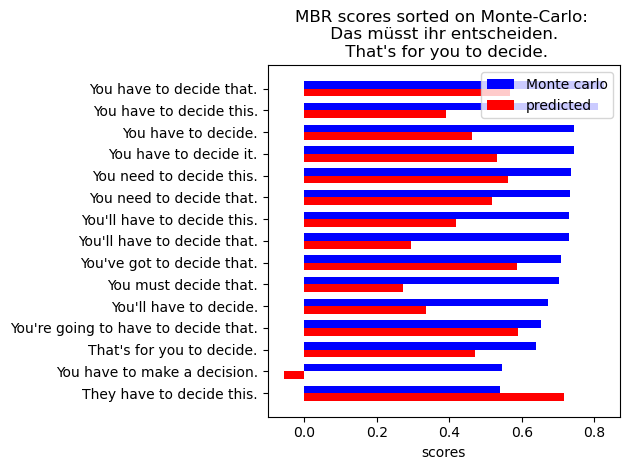

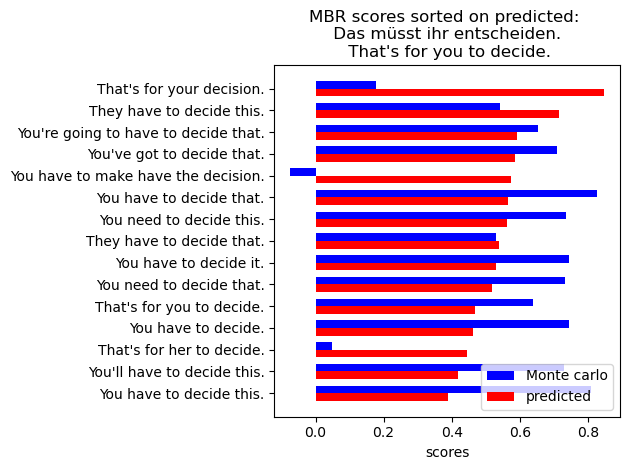

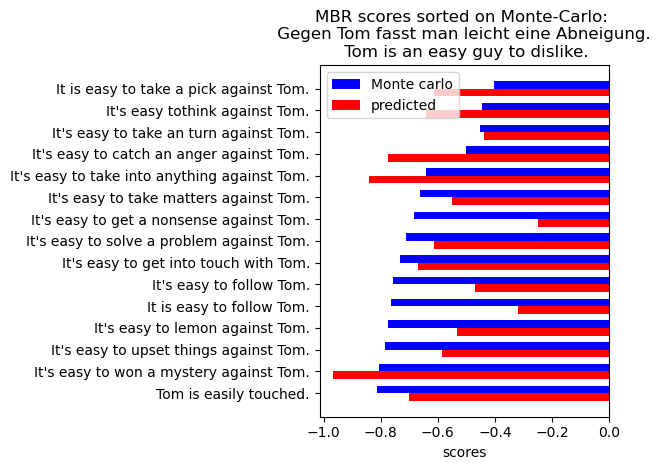

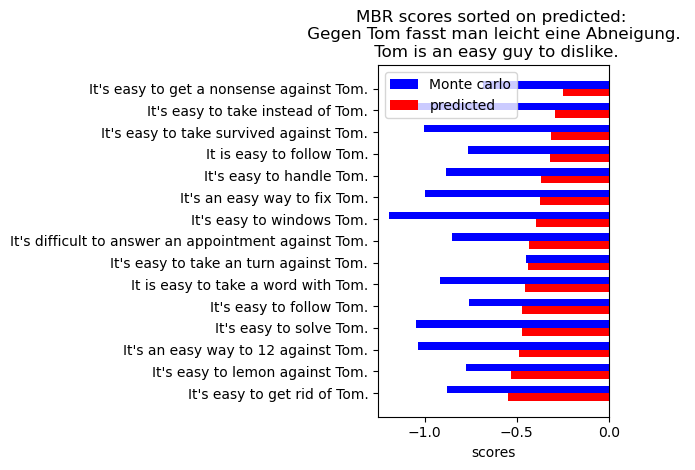

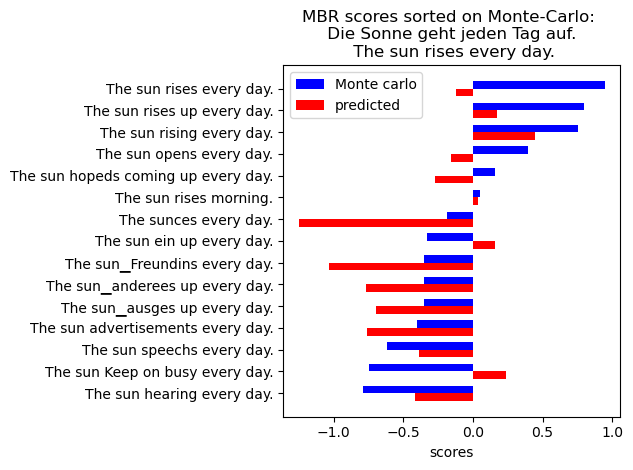

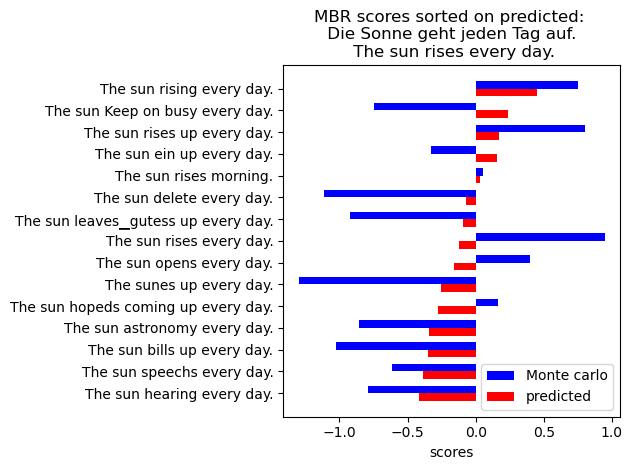

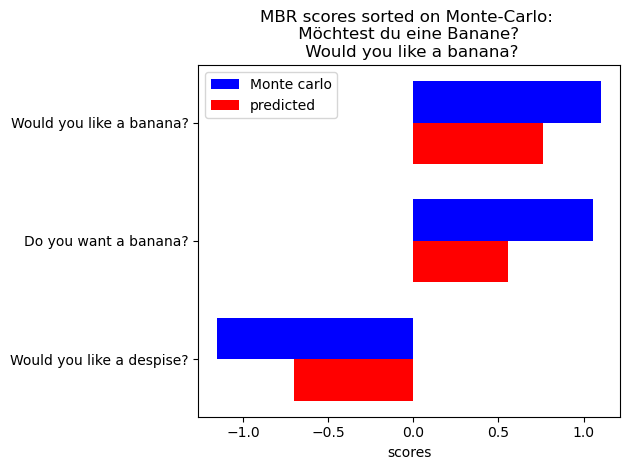

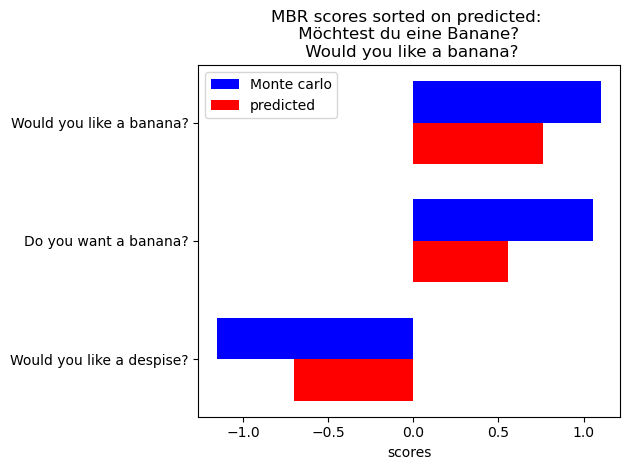

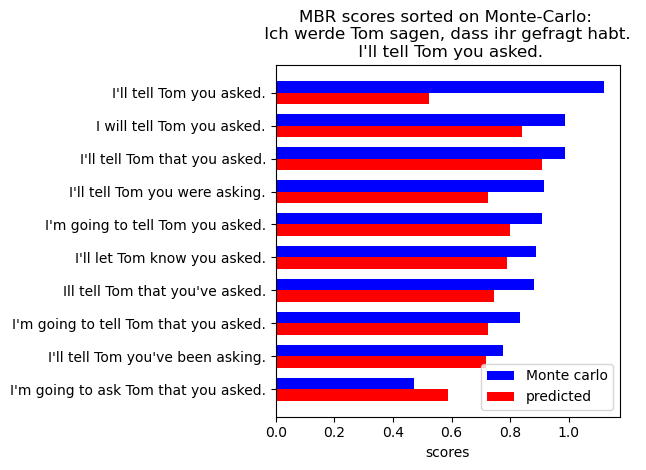

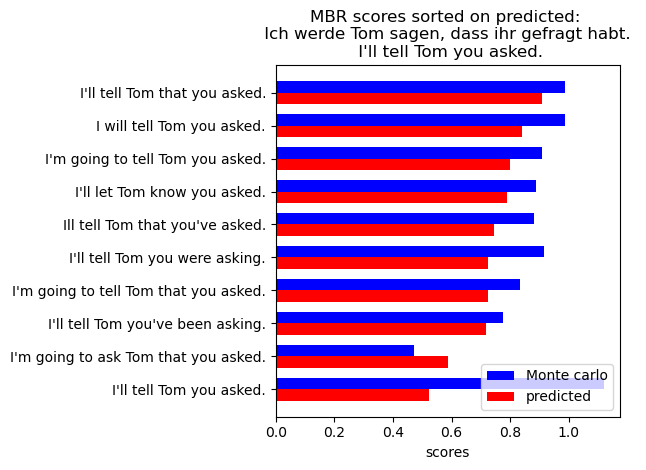

In [11]:
compare_random_scores(dataset.data, all_scores)

In [12]:
reference_scores = []
for i, row in dataset.data.iterrows():
    reference_scores.append(np.array(calculate_mbr_scores(row)))


In [13]:
## Next up we check if we are optimistic or pessimistic.

def calc_opt_statistics(predicted_scores, reference_scores):
    opt_count = 0
    pes_count = 0
    opt_sum = 0
    pes_sum = 0
    for pred_score, ref_score in zip(predicted_scores, reference_scores):
        larger = pred_score >= ref_score
        smaller = ref_score > pred_score
        opt_count += sum(larger)
        pes_count += sum(smaller)
        opt_sum += sum((pred_score - ref_score) * larger)
        pes_sum += sum((ref_score - pred_score) * smaller)
    total = opt_count + pes_count
    opt_percentage = opt_count/total
    pes_percentage = pes_count/total
    opt_avg = opt_sum/opt_count
    pes_avg = pes_sum/pes_count
        
    return {"opt_count": opt_count, "pes_count": pes_count, 
            "opt_sum": opt_sum, "pes_sum": pes_sum,
            "opt_percentage": opt_percentage,
            "pes_percentage": pes_percentage,
            "opt_avg": opt_avg,
            "pes_avg": pes_avg,
           }


In [14]:
statistics = calc_opt_statistics(all_scores, reference_scores)

In [15]:
statistics

{'opt_count': 3897,
 'pes_count': 3834,
 'opt_sum': 1120.1550061357786,
 'pes_sum': 1214.3070972233063,
 'opt_percentage': 0.5040745052386496,
 'pes_percentage': 0.4959254947613504,
 'opt_avg': 0.28744034029658166,
 'pes_avg': 0.3167206826351868}

In [16]:
### Here we get the predicted loc and scale for each sentence:
from tqdm import tqdm
all_model_out = []
for i, row in tqdm(dataset.data.iterrows(), total=dataset.data.shape[0]):
    source = row["source"]
    hypotheses = list(row["hypotheses"])

    model_out = wrapped_model.get_model_out([source]* len(hypotheses), hypotheses)
    all_model_out.append(model_out)
    if i > 200:
        break


  4%|███▏                                                                           | 201/5000 [00:11<04:30, 17.76it/s]


In [17]:
entry_id = 190
entry = dataset.data.iloc[entry_id]

In [18]:
def get_repeated_utils(utilities, count):
    
    repeated_utils = []
    for util in utilities:
        
        r = []
        for u, c in zip(util, count):
            r += [u] * c
        repeated_utils.append(r)
    return repeated_utils
    
    

In [19]:
# def Gauss(x, A, B):
#     y = A*np.exp(-1*B*x**2)
#     return y
import torch.distributions as td
import torch
def show_gaussian(loc, scale, data, source, target, hypothesis, save=False, path='./imgs/'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    cleaned_hypothesis = clean(hypothesis)
    
    # First plot the histogram
    ax.hist(data, 250, density=True, facecolor='g', alpha=0.75, label="scores")
    
    # Next up we plot the gaussian we tried to fit
    dist = td.Normal(loc, scale)
    
    x = torch.Tensor(np.linspace(loc - 2* scale, loc + 2 * scale, 100))
    probs = np.exp(dist.log_prob(x))
    
    ax.plot(x, probs, label="Predicted fit: \nLoc: {}, Scale: {}".format(str(round(loc, 2)), str(round(scale, 2))))
    
      
    middle_point = int(len(probs)/2)
    avg = np.mean(data)
    ax.scatter(avg, probs[middle_point], label="avg: {}".format(str(round(avg, 2))), marker="o")
    ax.scatter(loc, probs[middle_point], label="loc: {}".format(str(round(loc, 2))), marker="x")
   
    
    ax.set_xlabel('scores')
    ax.set_title('MBR scores histogram with Gaussian: \n {} \n {}'.format(source, hypothesis))
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('{}fitted_gaussian_{}_{}.png'.format(path, cleaned_source, cleaned_hypothesis))
    
    plt.show()



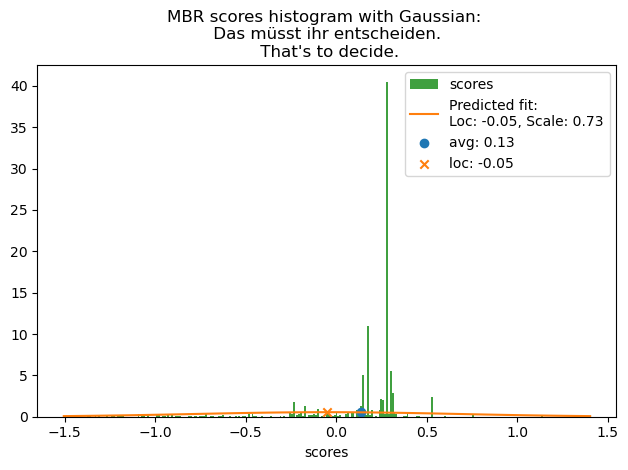

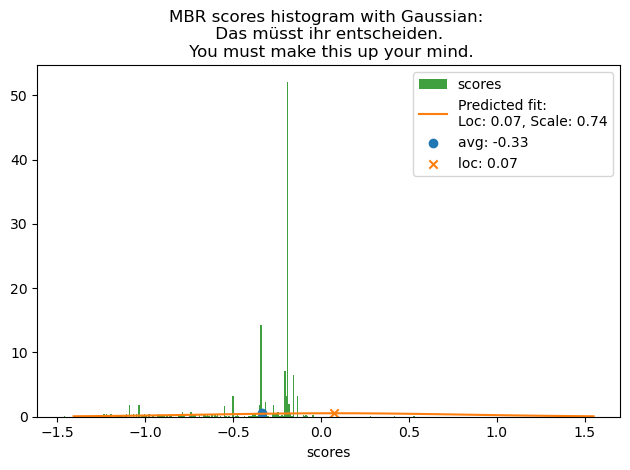

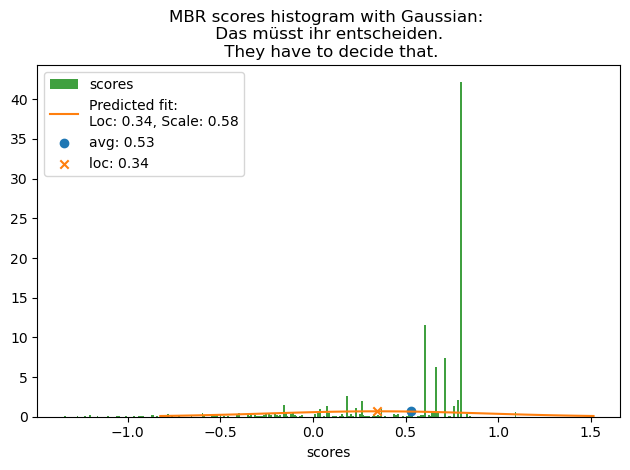

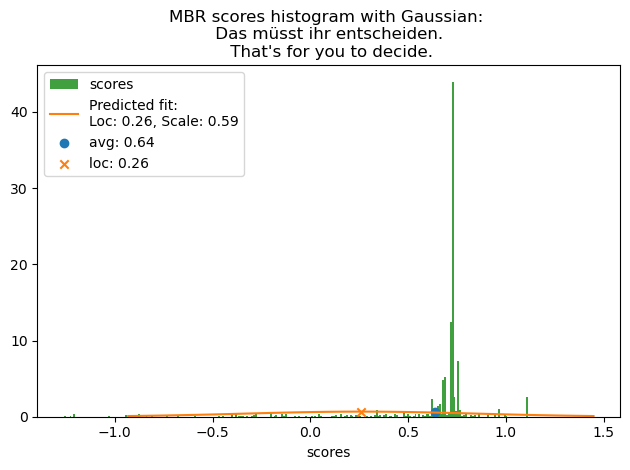

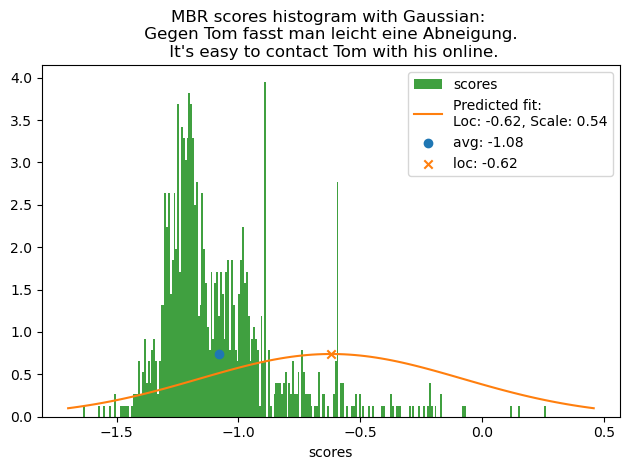

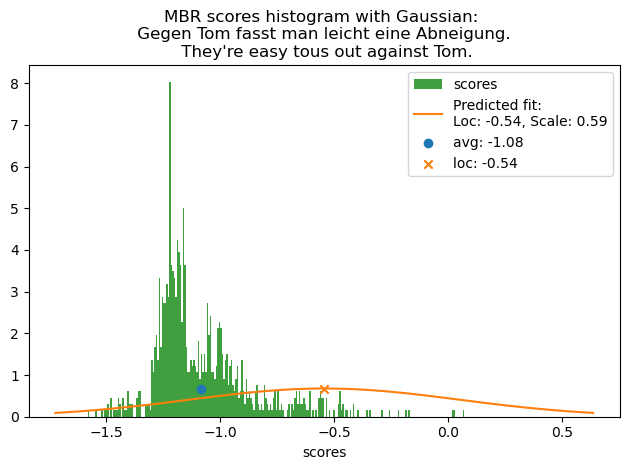

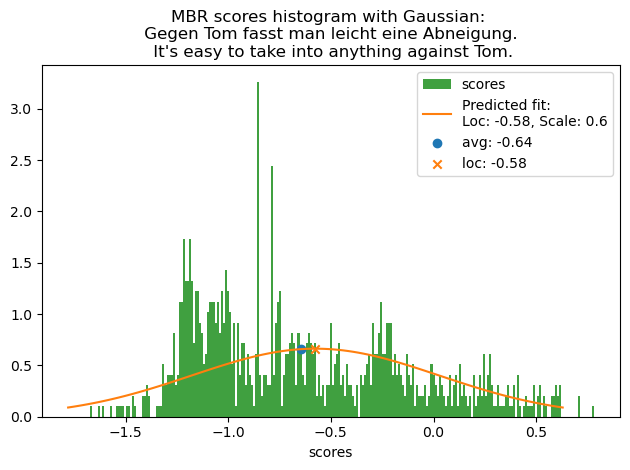

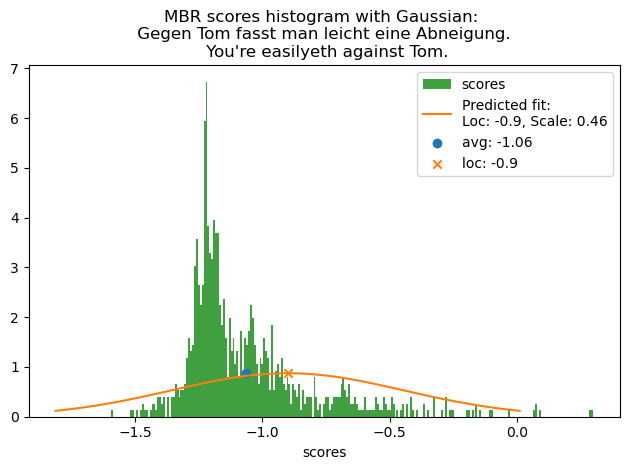

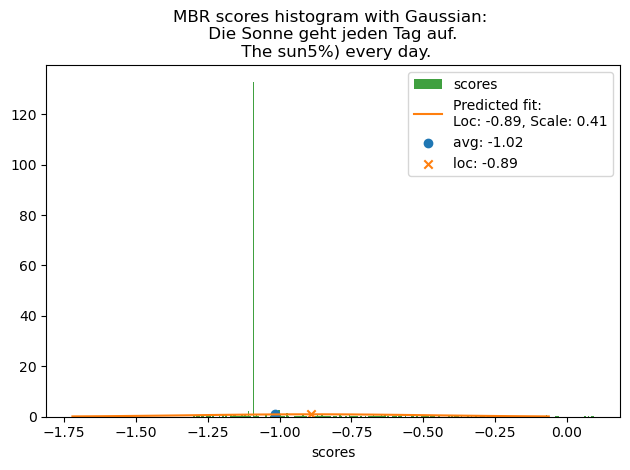

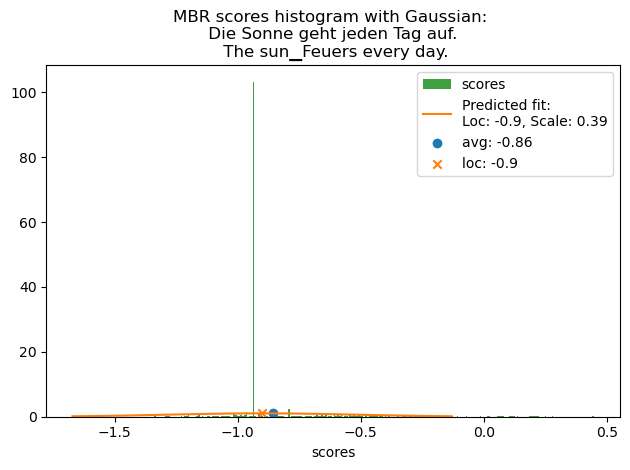

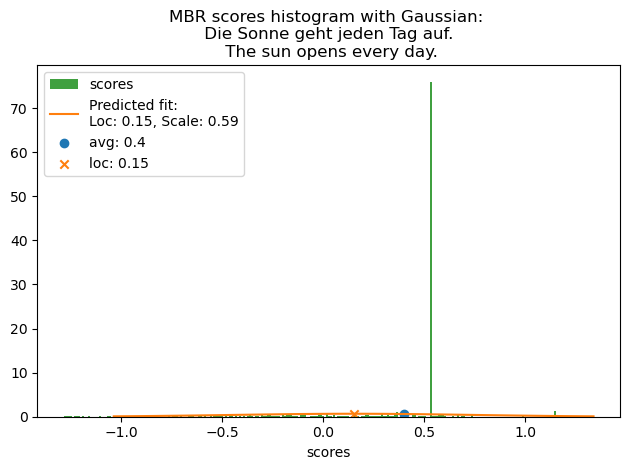

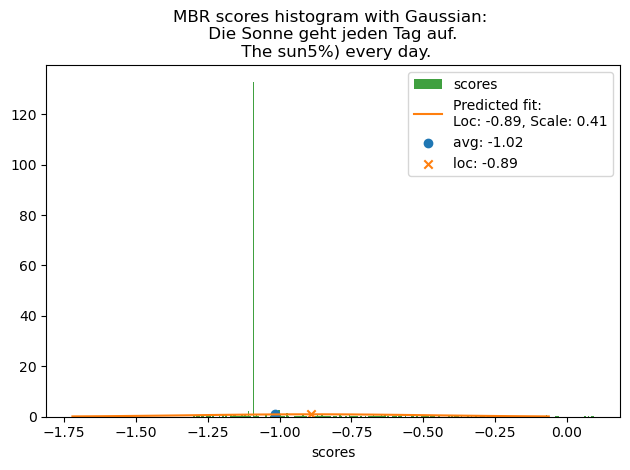

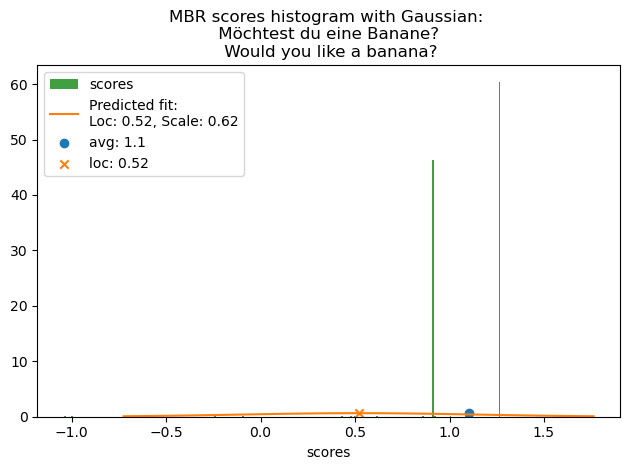

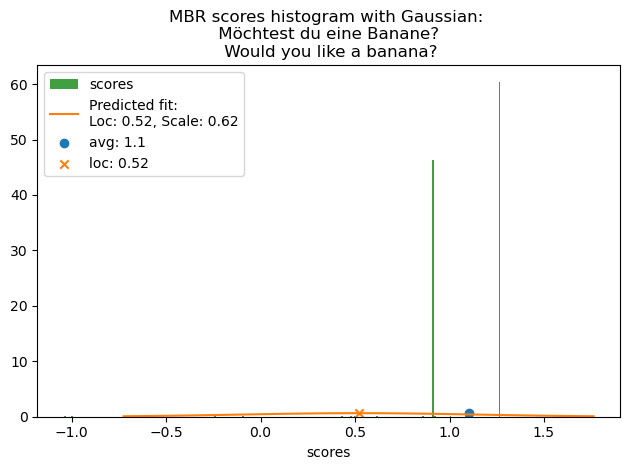

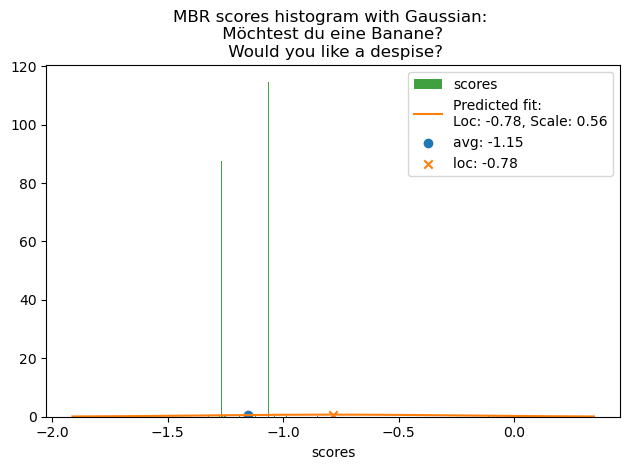

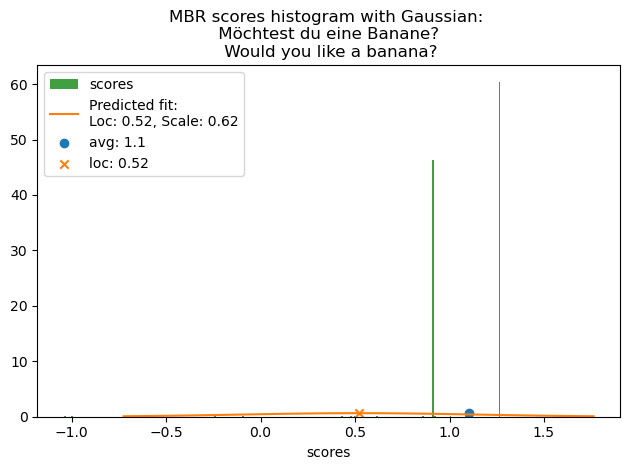

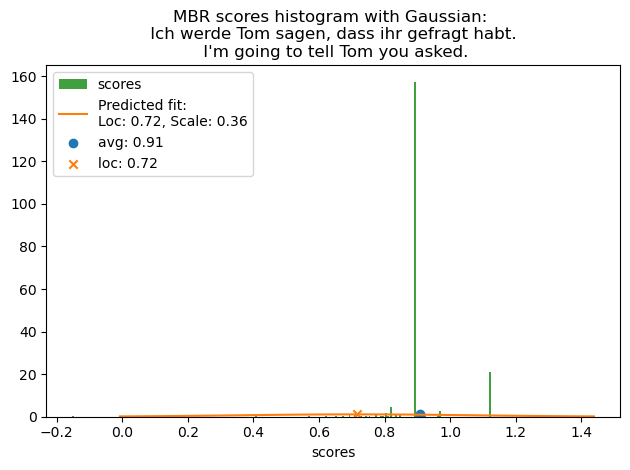

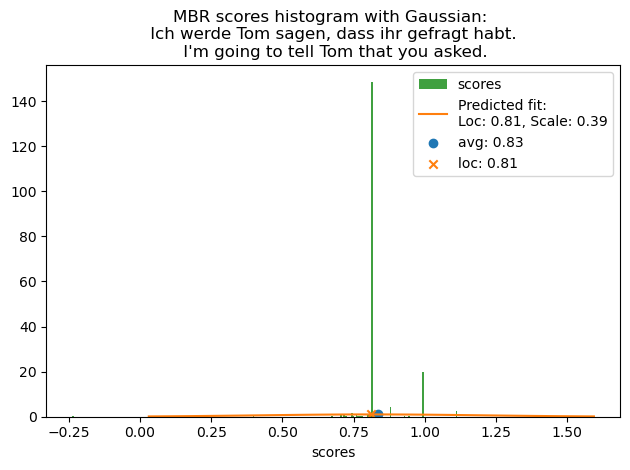

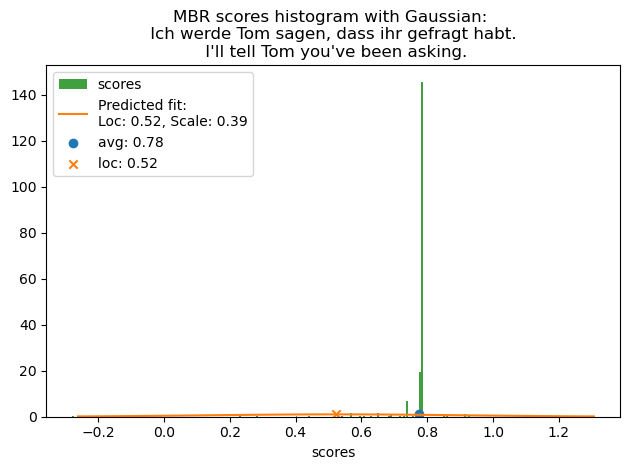

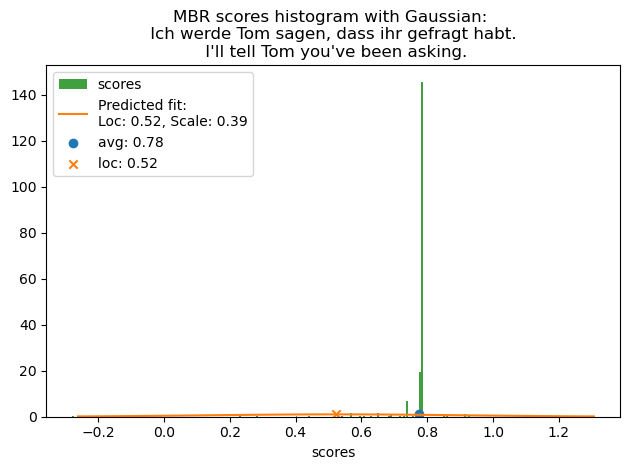

In [20]:
def compare_data_with_fit(data, fit, n_sources=5, n_hypotheses=4, seed=1):
    np.random.seed(seed)
    indices = np.random.choice(len(fit), size=n_sources)
    
    
    for i in indices:
        entry = data.iloc[i]
        repeated_utils = get_repeated_utils(entry["utilities"], entry["utilities_count"])
        hypotheses_indices = np.random.choice(len(entry["utilities"]), size=n_hypotheses)
        for hypothesis_index in hypotheses_indices:
            hypothesis = entry["hypotheses"][hypothesis_index]
            target = entry["target"]
            source = entry["source"]

            utils = repeated_utils[hypothesis_index]

            loc = fit[i]["loc"][hypothesis_index]
            scale = fit[i]["scale"][hypothesis_index]

            show_gaussian(loc, scale, utils, source, target, hypothesis, save=True, path="./test_imgs/")

compare_data_with_fit(dataset.data, all_model_out, )      
# loc = all_model_out[entry_id]["loc"][4]
# scale = all_model_out[entry_id]["scale"][4]
# show_gaussian(loc, scale, repeated_utils[4])
# print(loc)
# print(scale)

In [21]:
#train dataset
dataset_loader = BayesRiskDatasetLoader("train_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset_train = dataset_loader.load(type="pandas")

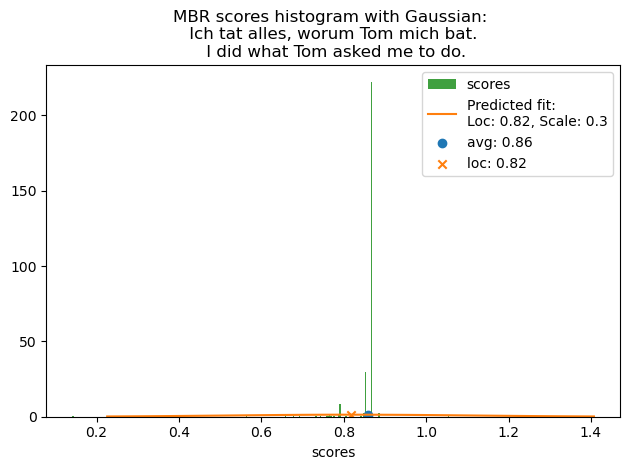

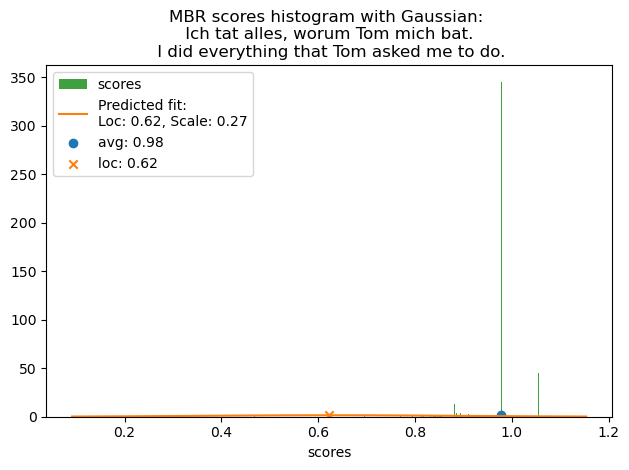

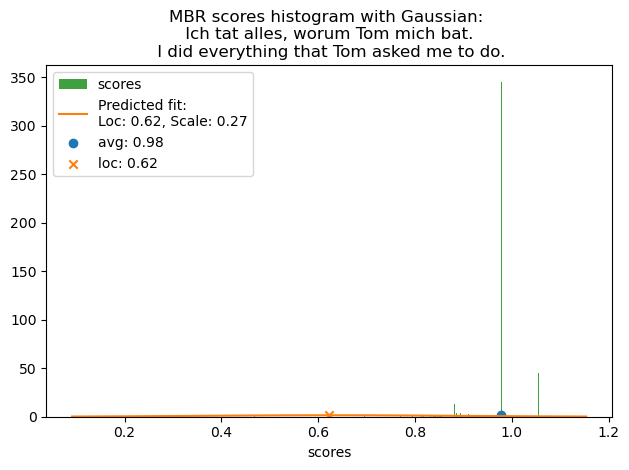

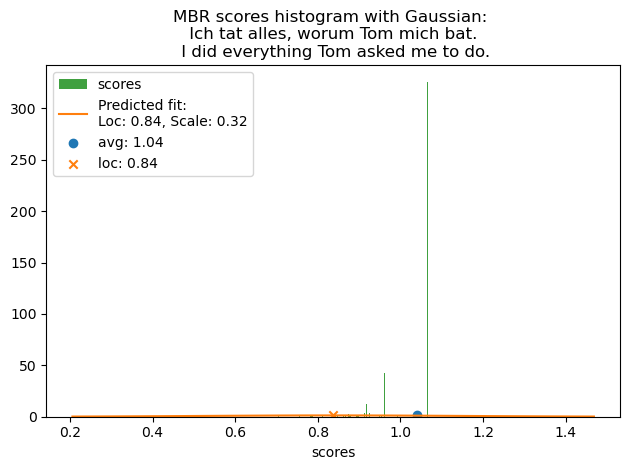

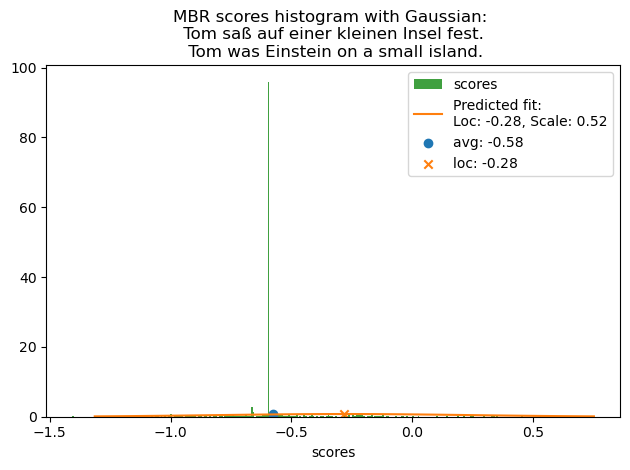

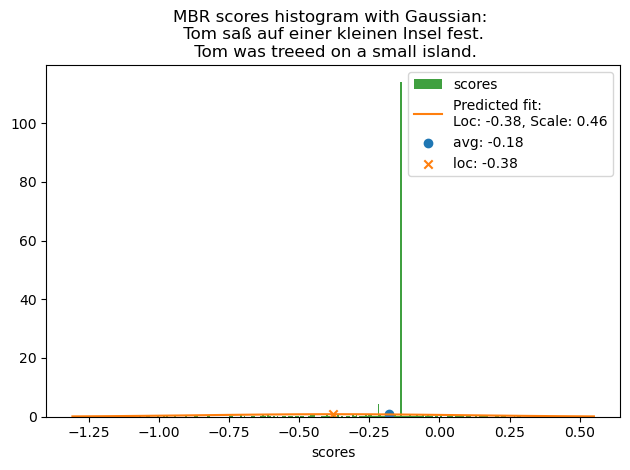

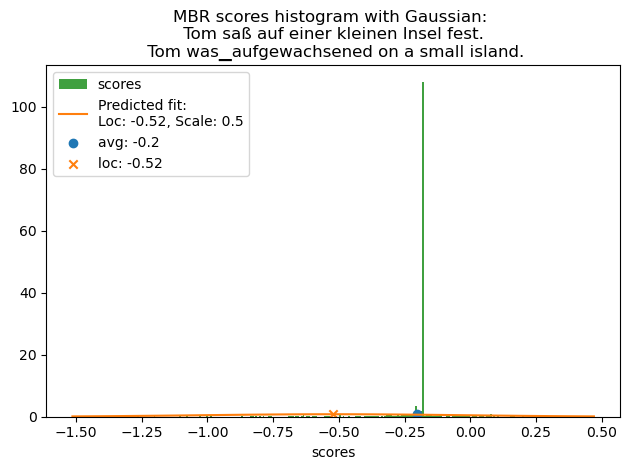

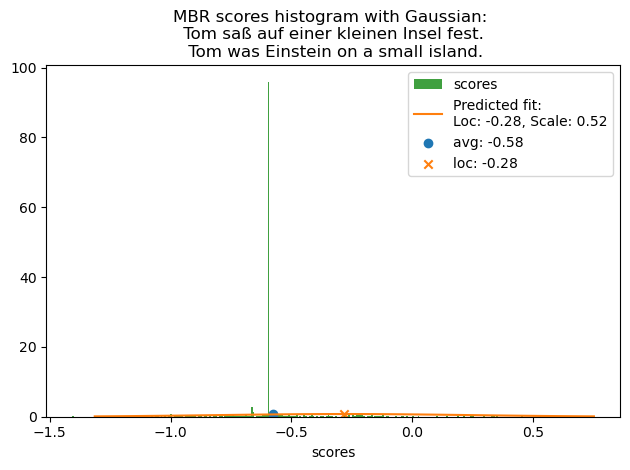

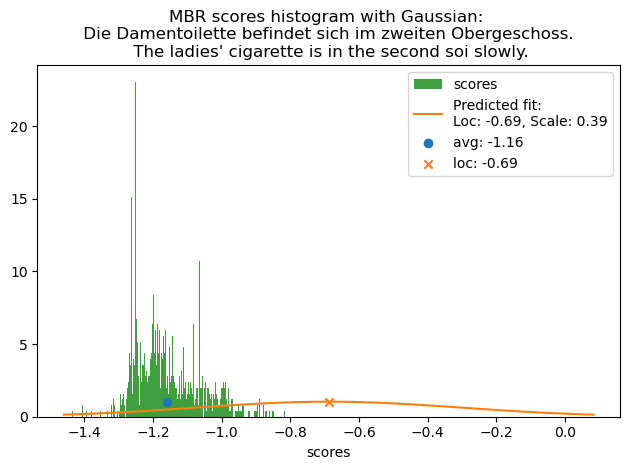

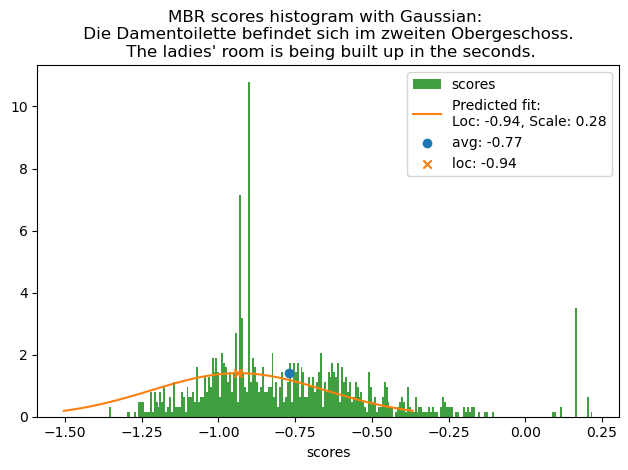

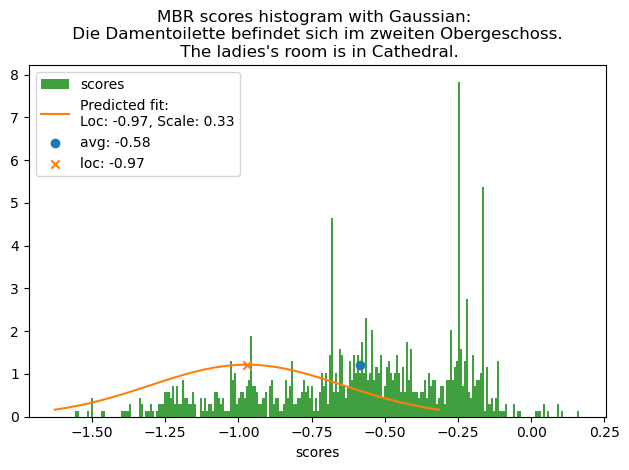

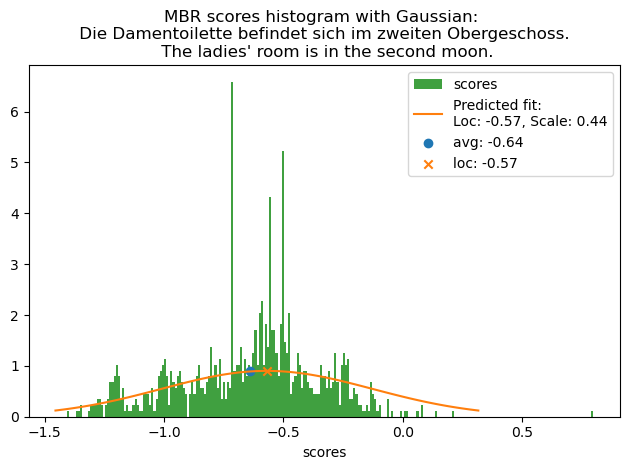

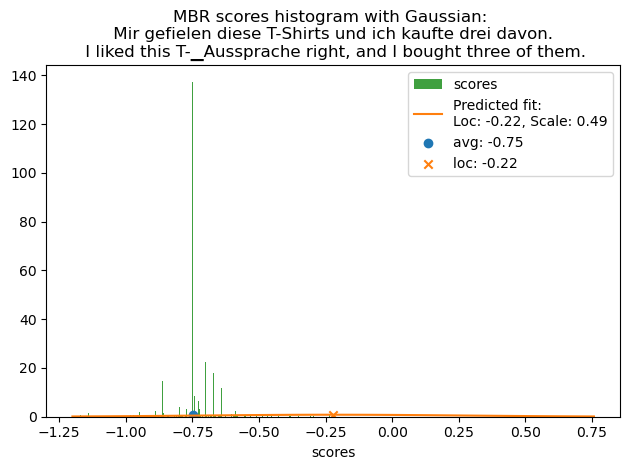

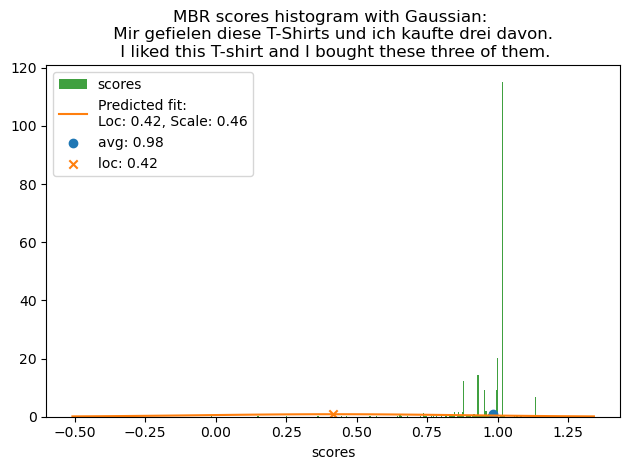

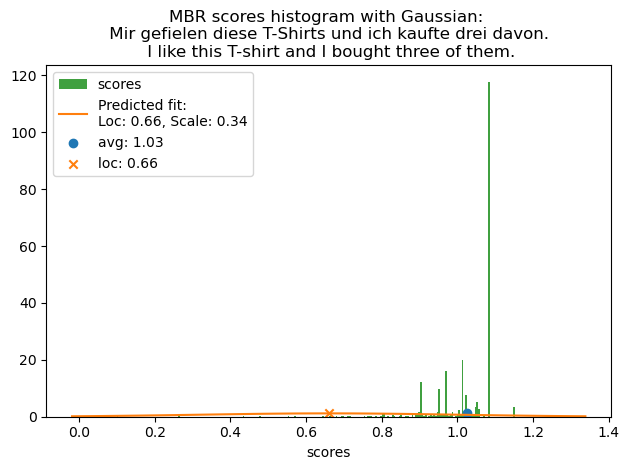

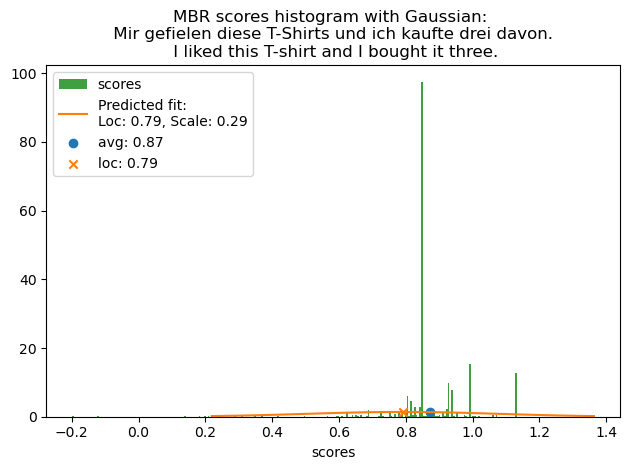

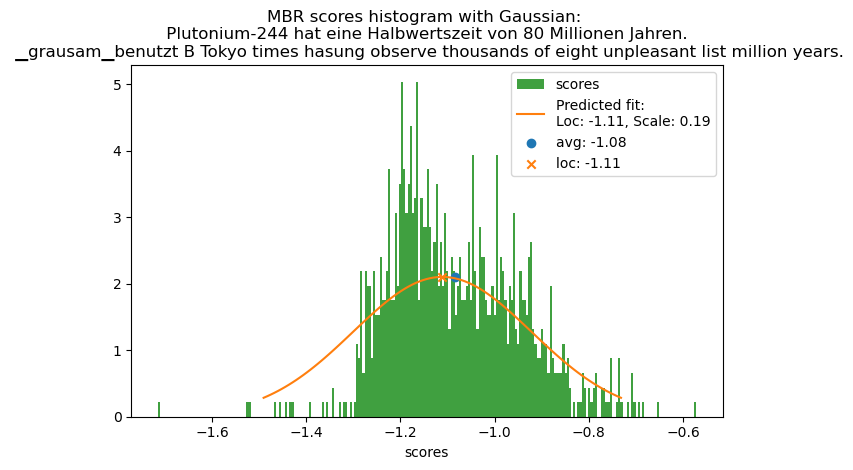

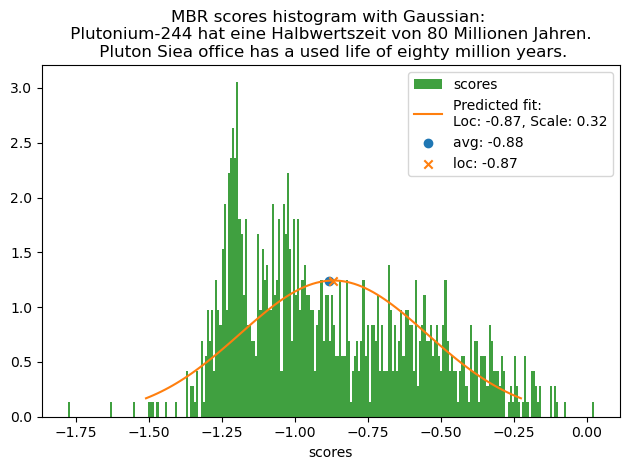

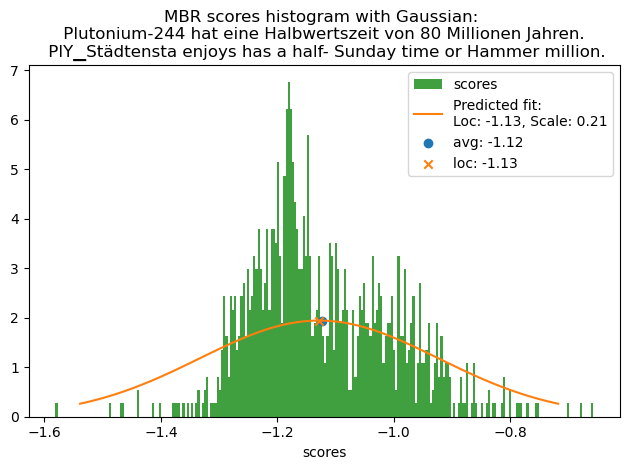

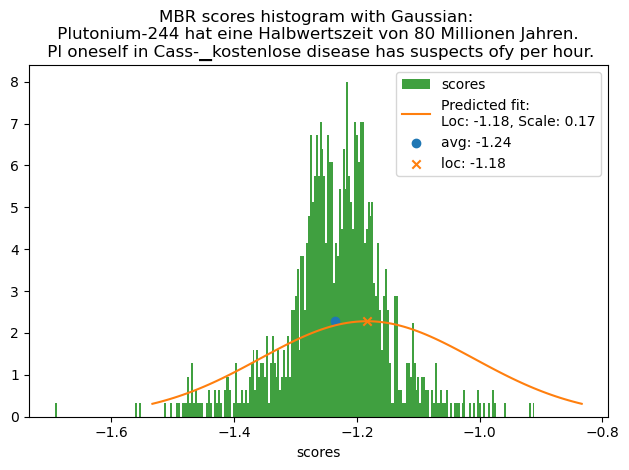

In [22]:
def compare_data_on_model(df, model, n_sources=5, n_hypotheses=4, seed=1):
    
    np.random.seed(seed)
    indices = np.random.choice(len(df["utilities"]), size=n_sources)
    
    for i in indices:
        row = df.iloc[i]
        source = row["source"]
        target = row["target"]
        hypotheses = list(row["hypotheses"])
        repeated_utils = get_repeated_utils(row["utilities"], row["utilities_count"])
        model_out = wrapped_model.get_model_out([source]* len(hypotheses), hypotheses)
        
        hypothesis_indices = np.random.choice(len(hypotheses), size=n_hypotheses)
        
        for h_i in hypothesis_indices:
            loc = model_out['loc'][h_i]
            scale = model_out['scale'][h_i]
            
            utils = repeated_utils[h_i]
            hypothesis = hypotheses[h_i]
            show_gaussian(loc, scale, utils, source, target, hypothesis, save=True, path="./train_imgs/")
        
    


compare_data_on_model(dataset_train.data, wrapped_model)    